Import required modules

In [1]:
%matplotlib inline
import numpy as np
import sys, os, re

import LISAConstants as LC

from LISAhdf5 import LISAhdf5,ParsUnits,Str
from optparse import OptionParser
import GenerateFD_SignalTDIs as GenTDIFD
import tdi
import matplotlib.pyplot as plt

DirLDC = '/codes/LDC/'
DirScript = '../software/LDCpipeline/scripts/'
### We go to the directory DirScript and run everything from there
os.chdir(DirScript)


/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


FileNotFoundError: [Errno 2] No such file or directory: '../software/LDCpipeline/scripts/'

# Define the name of hdf5 file (root name) and the seed

In [ ]:
fNh5 = "MBBH_RadlerTest_seed1911.hdf5"
seed = 1911

## Define the useful functions

In [6]:

def CheckSNRreq(par, source):
    start_block = False
    fin = open(par, 'r')
    sourceThere = False
    SNRrange = None
    for line in fin:
        #print line
        if (re.search("===", line)):
            if (start_block == True):
                start_block = False
                #print "End the block"
            else:
                start_block = True
                #print "Begin the block"
        #print "Start_bloack", start_block
        if (start_block == True):
            #print "True"
            if (re.search("SourceType", line)):
            #if (re.search(line, "Source")):
                fd = re.split("\s+", line)
                if (fd[1] == source):
                    print ("found", source)
                    sourceThere = True
            if (sourceThere):
                if (re.search("RequestSNR", line)):
                    fd = re.split("\s+", line)
                    SNRs = fd[1]
                    SNRs = re.split("-", SNRs)
                    SNRrange = [float(SNRs[0]), float(SNRs[1])]

    return(SNRrange)

def ComputeNorm(x, S, fr):
    #{{{
    df = fr[1]-fr[0]
    SNR2 = 4.0*df * np.sum(np.absolute(x)**2/S)
    #print ("df = ", df)
    # plt.loglog(fr, S)
    # plt.loglog(fr, np.real(x*np.conjugate(x)) )
    # #plt.loglog(fr, np.absolute(x) )
    # plt.show()
    return (SNR2)
    #}}}

def ComputeSNR_MBHB(pMBHB):
    #{{{
    if Str(pMBHB.get('Approximant'))=='IMRPhenomD':
        print ("Yes, requested IMRP_D model, we can proceed")
    else:
        print ("Unknown FD model:", Str(pMBHB.get('Approximant')))
        raise NotImplementedError

    fr, Xf, Yf, Zf = GenTDIFD.ComputeMBHBXYZ_FD(pMBHB)

    ix = np.argwhere(np.absolute(Xf) > 0.0)[0][0]
    Af = (Zf - Xf)/np.sqrt(2.0)
    Ef = (Xf - 2.0*Yf + Zf)/np.sqrt(6.0)
    Tf = (Xf + Yf + Zf)/np.sqrt(3.0)

    Sa = tdi.noisepsd_AE(fr[ix:], model='Proposal', includewd=None)
    St = tdi.noisepsd_T(fr[ix:], model='Proposal')

    SNR2A = ComputeNorm(Af[ix:], Sa, fr[ix:])
    SNR2E = ComputeNorm(Ef[ix:], Sa, fr[ix:])
    SNR2T = ComputeNorm(Tf[ix:], St, fr[ix:])
    SNR = np.sqrt(SNR2A + SNR2E + SNR2T)

    return(SNR)
    #}}}

def FindSNRsource():
    #{{{
    snrInRange = False
    trial = 1
    verbose = True
    #print (str(seed))
    while not snrInRange:
        print ("python ChooseSources.py --verbose  --paramFile=" + parFile + " --filename=" + fNh5 + " --seed=" + str(seed))
        os.system("python ChooseSources.py --verbose  --paramFile=" + parFile + " --filename=" + fNh5 + " --seed=" + str(seed))
        fh5 = LISAhdf5(fNh5)
        NSrc = fh5.getSourcesNum()
        GWs = fh5.getSourcesName()
        if (verbose):
            print ("Found %d GW sources: " % NSrc, GWs)
        for GW in GWs:
            if (re.search("MBHB", GW)):
                BBH = GW
                if (verbose):
                    print ("Found MBHB:", BBH)
        ### FIXME what if MBHB is not found?
        pMBHB = fh5.getSourceParameters(BBH)
        #if verbose:
        #    pMBHB.display()

        SNR = ComputeSNR_MBHB(pMBHB)
        print ("Source SNR = ", SNR)
        if (SNR >= SNRs[0] and SNR <= SNRs[1]):
            print ("found MBHB with SNR ", SNR, "inside the required range:", SNRs)
            return(BBH)
            snrInRange = True
        if trial == 1000:
            print ("Cannot find find MBHB with the required SNR", SNRs)
            print ("Too many trials, either change the SNR range or add more catalogues")
            sys.exit(1)
    #}}}


Define the location of the parameter file

In [7]:
#!cp ../software/LDCpipeline/scripts/Param_RadlerMBHB.txt .
parFile = "Param_RadlerMBHB.txt"
if not os.path.isfile(parFile):
    print("par file "+parFile+" not found!")
    

## Choose the source based on the param file

In [8]:
SNRs = CheckSNRreq(parFile, "MBHB") ### gettimng SNR range if specified
print (SNRs)
if (SNRs != None):
    BBH = FindSNRsource()
else:
    if (options.verbose):
        print ("SNR is not required choosing the random source")
        os.system("ls")
        os.system("python " + DirScript+"ChooseSources.py --verbose --paramFile=" + parFile + " --filename=" + fNh5 + " --seed=" + str(seed))

fh5 = LISAhdf5(fNh5)
NSrc = fh5.getSourcesNum()
#GWs = fh5.getSourcesName()

pMBHB = fh5.getSourceParameters(BBH)
SNR = ComputeSNR_MBHB(pMBHB)

print ("num sources: ", NSrc)
print ("The chosen source:")
pMBHB.display()
print ("Combined Snr = ", SNR)

found MBHB
[100.0, 500.0]
python ChooseSources.py --verbose  --paramFile=Param_RadlerMBHB.txt --filename=MBBH_RadlerTest_seed1911.hdf5 --seed=1911
Found 1 GW sources:  ['MBHB-0']
Found MBHB: MBHB-0
Yes, requested IMRP_D model, we can proceed
 Stas - > fmin  6.64146346173e-06 6.64146346173e-06 6.64146346173e-06 False
 Stas - > fmax  1.0 0.00157018203906 0.00157018203906 False
Stas again minf_rs =  8.773698254112591e-06 -41943040.0 -87611931.6228
Shifts: 749.001155923
Source SNR =  303.210163245
found MBHB with SNR  303.210163245 inside the required range: [100.0, 500.0]
Yes, requested IMRP_D model, we can proceed
 Stas - > fmin  6.64146346173e-06 6.64146346173e-06 6.64146346173e-06 False
 Stas - > fmax  1.0 0.00157018203906 0.00157018203906 False
Stas again minf_rs =  8.773698254112591e-06 -41943040.0 -87611931.6228
Shifts: 749.001155923
num sources:  1
The chosen source:
	Approximant IMRPhenomD [ModelName]
	AzimuthalAngleOfSpin1 5.05978711159 [Radian]
	AzimuthalAngleOfSpin2 1.681147706

## Generate FD signal (no noise)

In [9]:
### create hdf5 file where we store the data
tmpf1_h5 = fNh5[:-5] + "_FD_NoNoise.hdf5"
#print (tmp_h5)
os.system("cp "+ fNh5 + "  " + tmpf1_h5)

fr, Xf, Yf, Zf = GenTDIFD.ComputeMBHBXYZ_FD(pMBHB)
del_t = pMBHB.get("Cadence")
tm, Xt, Yt, Zt = GenTDIFD.ComputeTD(Xf, Yf, Zf, del_t)
Tobs = pMBHB.get("ObservationDuration")

i_end = np.argwhere(tm > Tobs)[0][0]

# Write the FD data to the hdf5file
f1h5 = LISAhdf5(tmpf1_h5)
tdis = np.transpose(np.array([tm[:i_end],Xt[:i_end],Yt[:i_end],Zt[:i_end]]))
f1h5.addPreProcess(ParsUnits(), overwrite=True, TDIdata=tdis)

 Stas - > fmin  6.64146346173e-06 6.64146346173e-06 6.64146346173e-06 False
 Stas - > fmax  1.0 0.00157018203906 0.00157018203906 False
Stas again minf_rs =  8.773698254112591e-06 -41943040.0 -87611931.6228
Shifts: 749.001155923


## Generate TD signal (no noise)

1. Generate h+ hx

In [10]:
os.system("python Compute_hphc.py -v  " + fNh5)

0

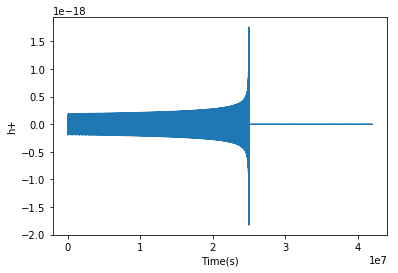

In [11]:
TD5 = LISAhdf5(fNh5)
thphc = TD5.getSourceHpHc('MBHB-0')
plt.plot(thphc[:,0],thphc[:,1])
plt.xlabel('Time(s)')
plt.ylabel('h+')
plt.show()

2 Configure LISA and noise

In [12]:
os.system("python ConfigureInstrument.py  --duration=41943040.0  --timeStep=10.0  --orbits='MLDC_Orbits'  " + fNh5)
os.system("python ConfigureNoises.py  " + fNh5)


0

3 Generate and record the TDIs without noise

In [14]:
tmpt1_h5 = fNh5[:-5] + "_TD_NoNoise.hdf5"
os.system("cp "+ fNh5 + "  " + tmpt1_h5)
os.system("python RunSimuLC2.py  --NoNoise  -v  "  + tmpt1_h5)


0

# Testing: Compare TD and FD signals

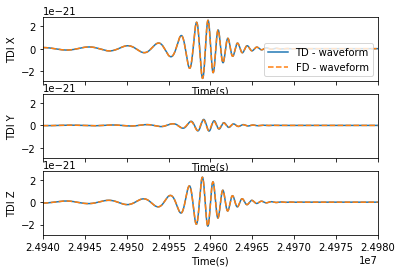

In [16]:
TD5 = LISAhdf5(tmpt1_h5)
tdTDI = TD5.getPreProcessTDI()
FD5 = LISAhdf5(tmpf1_h5)
fdTDI = FD5.getPreProcessTDI()

fig, ax = plt.subplots(3, sharex=True, sharey=True)
ax[0].plot(tdTDI[:,0],tdTDI[:,1], label="TD - waveform")
ax[0].plot(fdTDI[:,0],fdTDI[:,1], '--', label='FD - waveform')
ax[0].set_xlabel('Time(s)')
ax[0].set_ylabel('TDI X')
ax[0].set_xlim([2.494e7, 2.498e7])
ax[0].legend(loc=4)

ax[1].plot(tdTDI[:,0],tdTDI[:,2])
ax[1].plot(fdTDI[:,0],fdTDI[:,2], '--')
ax[1].set_xlabel('Time(s)')
ax[1].set_ylabel('TDI Y')

ax[2].plot(tdTDI[:,0],tdTDI[:,3])
ax[2].plot(fdTDI[:,0],fdTDI[:,3], '--')
ax[2].set_xlabel('Time(s)')
ax[2].set_ylabel('TDI Z')

plt.show()

## Generate the data with the noise

Generate TD data with the noise

In [12]:
tmpt2_h5 = fNh5[:-5] + "_TD.hdf5"
os.system("cp " + fNh5 + "  " + tmpt2_h5)
os.system("python RunSimuLC2.py   -v  "  + tmpt2_h5)

0

Generate FD data with the noise

In [13]:
tmpf2_h5 = fNh5[:-5] + "_FD.hdf5"
os.system("cp " + fNh5 + "  " + tmpf2_h5)
os.system("python RunSimuLC2.py --NoGW  -v  "  + tmpf2_h5)
### read the noise
SFD5 = LISAhdf5(tmpf2_h5)
SfdTDI = SFD5.getPreProcessTDI()
#### adding the signal to the noise
SfdTDI[:, 1] = fdTDI[:, 1] + SfdTDI[:, 1]
SfdTDI[:, 2] = fdTDI[:, 2] + SfdTDI[:, 2]
SfdTDI[:, 3] = fdTDI[:, 3] + SfdTDI[:, 3]
SFD5.addPreProcess(ParsUnits(), overwrite=True, TDIdata=SfdTDI)

Plot the FD data with noise and overplot it without

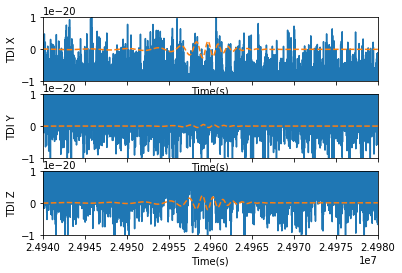

In [14]:
SFD5 = LISAhdf5(tmpf2_h5)
SfdTDI = SFD5.getPreProcessTDI()
fig, ax = plt.subplots(3, sharex=True, sharey=True)
ax[0].plot(SfdTDI[:,0],SfdTDI[:,1])
ax[0].plot(fdTDI[:,0],fdTDI[:,1], '--')
ax[0].set_xlabel('Time(s)')
ax[0].set_ylabel('TDI X')
ax[0].set_xlim([2.494e7, 2.498e7])
ax[0].set_ylim([-1.e-20, 1.e-20])
ax[0].legend(loc=4)

ax[1].plot(SfdTDI[:,0],SfdTDI[:,2])
ax[1].plot(fdTDI[:,0],fdTDI[:,2], '--')
ax[1].set_xlabel('Time(s)')
ax[1].set_ylabel('TDI Y')

ax[2].plot(SfdTDI[:,0],SfdTDI[:,3])
ax[2].plot(fdTDI[:,0],fdTDI[:,3], '--')
ax[2].set_xlabel('Time(s)')
ax[2].set_ylabel('TDI Z')
plt.show()

Plot the TD data with noise and overplot it without

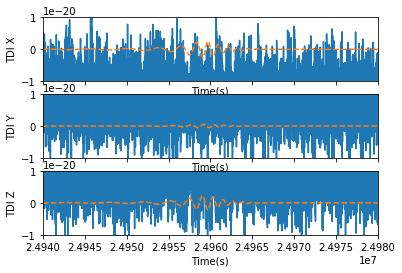

In [15]:
STD5 = LISAhdf5(tmpt2_h5)
StdTDI = SFD5.getPreProcessTDI()
fig, ax = plt.subplots(3, sharex=True, sharey=True)
ax[0].plot(StdTDI[:,0],StdTDI[:,1])
ax[0].plot(tdTDI[:,0],tdTDI[:,1], '--')
ax[0].set_xlabel('Time(s)')
ax[0].set_ylabel('TDI X')
ax[0].set_xlim([2.494e7, 2.498e7])
ax[0].set_ylim([-1.e-20, 1.e-20])
ax[0].legend(loc=4)

ax[1].plot(StdTDI[:,0],StdTDI[:,2])
ax[1].plot(tdTDI[:,0],tdTDI[:,2], '--')
ax[1].set_xlabel('Time(s)')
ax[1].set_ylabel('TDI Y')

ax[2].plot(StdTDI[:,0],StdTDI[:,3])
ax[2].plot(tdTDI[:,0],tdTDI[:,3], '--')
ax[2].set_xlabel('Time(s)')
ax[2].set_ylabel('TDI Z')
plt.show()